In [1]:
data_loc = 'us'
file = f'../dataset/{data_loc}.csv' # choose the file want to read

import pandas as pd
df = pd.read_csv(file)  # read csv
df = pd.DataFrame(df) # trans into dataframe

import time as tm
time_start = tm.time() #開始計時

ip_time = dict()
special_chr = ["{", "}", "'", ":", " "]

vpn_nan = 0
vpn_server = dict()
for i in range(len(df)):
    # vpn_server
    vpn_point = df['vpnServerId'][i]
    if (pd.isna(vpn_point)): vpn_nan+=1
    elif vpn_point not in vpn_server: vpn_server[vpn_point] = 1
    elif vpn_point in vpn_server: vpn_server[vpn_point] += 1
        
    # ip_time
    raw_points = df['transactionList'][i]
    points = ''.join(e for e in raw_points if e not in special_chr)
    points = points.split(",")
    for j in range(len(points)):
        time = points[j][:17]
        ip = points[j][17:]
        if ip not in ip_time:
            ip_time[ip] = [time]
        else:
            ip_time[ip].append(time)

total_num = len(ip_time)
print(f'num of total server: {total_num}')
print(f'vpn_nan: {vpn_nan}')
print(vpn_server)
time_end = tm.time()
time_c = time_end - time_start
print(f'time cost: {time_c}') # about (sec)
print(f'the size of data {len(df)}')

C:\Users\Hsu_Cheng\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


num of total server: 619
vpn_nan: 157086
{'us8261': 93, 'us6286': 23667, 'us8262': 29627, 'us8667': 38461, 'us8258': 6627, 'us8275': 2088, 'us8272': 26600}
time cost: 71.26015901565552
the size of data 284249


In [2]:
#import sklearn to cluster
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot
import numpy as np

from sklearn.decomposition import PCA # use pca reduce dims
from mpl_toolkits.mplot3d import Axes3D # plot 3d figure
from s_dbw import S_Dbw # evaluate clustering

from sklearn.cluster import MeanShift # a clustering algorithm decide the n_cluster automatically
from itertools import cycle # for mean-shift plot

import random # random choose servers

In [28]:
# dataset pre-processing
# select specific period from ip_time

def get_ip_time(ip_data=ip_time, period='2021', period_ip_time=None): # period_ip_time: use to accumulate date
    if period_ip_time is None:
        period_ip_time = dict()
    if type(period) == str:
        len_p = len(period)
        for ip in ip_data:
            for time in ip_data[ip]:
                if time[0:len_p] == period:
                    if ip not in period_ip_time:
                        period_ip_time[ip] = [time]
                    else:
                        period_ip_time[ip] += [time]
    elif type(period) == list: #[time_1, time_2, ...]
        period_ip_time = get_ip_time(period=period[0])
        for time_i in period[1:]:
            period_ip_time = get_ip_time(period=time_i, period_ip_time=period_ip_time)
    return period_ip_time

#data_2021 = get_ip_time(period='2021')

period_0 = ['2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05']
period_1 = ['2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
                     '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16']

data_period_0 = get_ip_time(ip_data=ip_time, period=period_0)
data_period_1 = get_ip_time(ip_data=ip_time, period=period_1)

for ip in data_period_0:
    print(ip)
    print(data_period_0[ip][:5])
    break

52.223.228.27
['2021-04-29T010109', '2021-04-29T012715', '2021-04-29T012547', '2021-04-29T013252', '2021-04-29T020213']


In [29]:
# choose data

data_choose = data_period_1
# data_choose = data_continuous

# setup hour axis for below chart
hour_axis = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

In [30]:
# check number of ips in data_ip_time
# data_continuous should has 538 ips

print(f'num of ip: {len(data_choose)}')

num of ip: 538


In [31]:
# sort time in data_ip_time (of each ip)
for ip in data_choose:
    data_choose[ip] = sorted(data_choose[ip])

# check result
for key, value in data_choose.items():
    print(key)
    print(value[0:5])
    break

52.223.228.27
['2021-05-07T000111', '2021-05-07T000455', '2021-05-07T000715', '2021-05-07T001040', '2021-05-07T001447']


[521, 522, 521, 511, 419, 331, 319, 319, 264, 173, 145, 132, 130, 130, 137, 144, 228, 366, 398, 469, 489, 504, 506, 508]


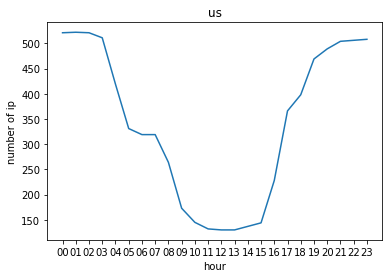

In [32]:
# number of ip in each hours

num_ip_hour = dict()
for hour in hour_axis:
    num_ip_hour[hour] = []
    
for ip in data_choose:
    for time in data_choose[ip]:
        hour = time[11:13]
        if ip not in num_ip_hour[hour]:
            num_ip_hour[hour].append(ip)

# plot - axis
y_num_ip = []
for hour in hour_axis:
    y_num_ip.append(len(num_ip_hour[hour]))

# plot
pyplot.title(f'{data_loc}')
pyplot.xlabel('hour')
pyplot.ylabel('number of ip')

pyplot.plot(hour_axis, y_num_ip)
print(y_num_ip)

In [8]:
def kmeans_cluster(model, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             #random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model)
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
        if type(plot) == list:
            pyplot.xlabel(plot[0])
            pyplot.ylabel(plot[1])
        clusters = np.unique(yhat)
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
        pyplot.show()
    score = S_Dbw(model, yhat)
    return yhat, score # len(yhat) = num of ip

def kmeans_cluster_3d_random(model, hour_period, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        model_3d = model
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             #random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model)
    if(show_centers):print(f'cluster_centers_: {kmeans.cluster_centers_}')
    if(plot):
        clusters = np.unique(yhat)
        # 2D plot
        if(pca_components):
            pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
            if type(plot) == list:
                pyplot.xlabel(plot[0])
                pyplot.ylabel(plot[1])
            for cluster in clusters:
                row_ix = np.where(yhat == cluster)
                pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
            pyplot.show()
        
        # 3D plot
        fig = pyplot.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
        ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
        ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')
        
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            ax.scatter(model_3d[row_ix, 0], model_3d[row_ix, 1], model_3d[row_ix, 2], color=colors[cluster])
            print(f'class_{cluster}({colors[cluster][4:]}): {[round(np.mean(model_3d[row_ix, 0])), round(np.mean(model_3d[row_ix, 1])), round(np.mean(model_3d[row_ix, 2]))]}')

        pyplot.show()

    score = S_Dbw(model, yhat)
    return yhat, score # len(yhat) = num of ip

print('def kmeans_cluster')

def kmeans_cluster


In [9]:
# get the 3-period features for each ip
# bug delete: 2022/6/4 (in the past, np>3 will wrong)

hour_period = [] # ex: [['00'~'07'], ['08'~'15'], ['16'~'23']] 
def get_ip_periods_count(ip, ip_time=data_choose, hour_period=hour_period):
    hour_count = np.zeros((len(hour_period),), dtype=int)
    for time in ip_time[ip]: # hour = time[11:13]
        for i in range(len(hour_period)):
            if time[11:13] in hour_period[i]:
                hour_count[i] += 1
    return hour_count

In [10]:
# output to csv file

def get_csv(yhat, ip_index, n_clusters, label):
    n_clusters = len(np.unique(yhat))
    ip_class = []
    for i in range(len(ip_index)):
        _class = f'class{yhat[i]}'
        ip_class.append([_class, ip_index[i]])
    
    df_class = pd.DataFrame(ip_class, columns=['class', 'ip'])
    file_name = f'./Af_oral/{data_loc}/p0_cluster_result/n_cluster_{n_clusters}/label_{label}.csv'
    df_class.to_csv(file_name)
    return 0

def output_s_dbw_record(record):
    df_class = pd.DataFrame(record, columns=['n_cluster', 'label', 'S_Dbw']) # add 'n_cluster'
    file_name = f'./Af_oral/{data_loc}/p0_cluster_result/s_dbw_record.csv'
    df_class.to_csv(file_name)
    return 0

In [16]:
# Run K-means 10 times for n_cluster=2~8, features of (n_period, slide_hour)

run_kmeans = False
if not (run_kmeans): print('skip run_kmeans')
elif run_kmeans:
    #data_2021
    time_start = tm.time()

    n_periods = 3
    slide_hour = 0

    period_len = len(hour_axis)//n_periods
    hour_period = [] # feature
    for i in range(n_periods-1):
        hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
    hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

    print(f'hour_period: {hour_period}')

    count_period = [] # feature vector for each ip
    ip_index = []
    for _ip in data_choose:
        period3 = get_ip_periods_count(_ip, data_choose, hour_period)
        count_period.append(period3)
        ip_index.append(_ip)
    X_count_hour = np.array(count_period)

    s_dbw_record = []
    for num_clusters in range(2,9):
        print(f'num_clusters={num_clusters}')
        for label in range(10):
            yhat_count_hour, score_count_hour = kmeans_cluster(X_count_hour, n_clusters=num_clusters, pca_components=2, plot=False, show_centers=False)
            get_csv(yhat=yhat_count_hour, ip_index=ip_index, n_clusters=num_clusters, label=label)
            s_dbw_record.append([num_clusters, label, score_count_hour]) # columns=['n_cluster', 'label', 'S_Dbw']
        time_c = tm.time() - time_start
        print(f'time cost: {time_c}') # (sec)

    # ouput s_dbw_record
    output_s_dbw_record(s_dbw_record)
    print('fininsh output s_dbw file')

skip run_kmeans


In [36]:
# output to csv file - random

def get_random_csv(yhat, ip_index, n_clusters, label, period):
    n_clusters = len(np.unique(yhat))
    ip_class = []
    for i in range(len(ip_index)):
        _class = f'class{yhat[i]}'
        ip_class.append([_class, ip_index[i]])
    
    df_class = pd.DataFrame(ip_class, columns=['class', 'ip'])
    file_name = f'./Af_oral/{data_loc}_period_{period}/random_nc_2to8/p0_cluster_result/n_cluster_{n_clusters}_label_{label}.csv'
    df_class.to_csv(file_name)
    return 0

def output_random_s_dbw_record(record, period):
    df_class = pd.DataFrame(record, columns=['n_cluster', 'label', 'S_Dbw']) # add 'n_cluster'
    file_name = f'./Af_oral/{data_loc}_period_{period}/random_nc_2to8/s_dbw_record.csv'
    df_class.to_csv(file_name)
    return 0

In [35]:
# Just randomly select servers and form 20 n-clusters for each n=2...8

def random_partition(list_in, n): # divide into n classes
    random.shuffle(list_in) # 隨機排列
    return [i%n for i in list_in]

print(f'number of ip: {len(data_choose)}')
server_index_list = [i for i in range(len(data_choose))]

period = 1
n_periods = 3
slide_hour = 0

period_len = len(hour_axis)//n_periods
hour_period = [] # feature
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

print(f'hour_period: {hour_period}')

# 3-period transaction count
count_period = [] # feature vector for each ip
ip_index = []
for _ip in data_choose:
    period3 = get_ip_periods_count(_ip, data_choose, hour_period)
    count_period.append(period3)
    ip_index.append(_ip)
X_count_hour = np.array(count_period)

s_dbw_record = []
for n_cluster in range(2,9):
    print(f'n_cluster={n_cluster}')
    for label in range(20):
        yhat = random_partition(server_index_list, n_cluster)
        score = S_Dbw(X_count_hour, yhat)
        get_random_csv(yhat=yhat, ip_index=ip_index, n_clusters=n_cluster, label=label, period=period)
        s_dbw_record.append([n_cluster, label, score]) # columns=['n_cluster', 'label', 'S_Dbw']
        
output_random_s_dbw_record(record=s_dbw_record, period=period)
print(f'finish random divide')

number of ip: 538
hour_period: [['00', '01', '02', '03', '04', '05', '06', '07'], ['08', '09', '10', '11', '12', '13', '14', '15'], ['16', '17', '18', '19', '20', '21', '22', '23']]
n_cluster=2
n_cluster=3
n_cluster=4
n_cluster=5
n_cluster=6
n_cluster=7
n_cluster=8
finish random divide


In [ ]:
# declaring list
#list = [2, 2, 4, 6, 6, 8]
_list = [i for i in range(1,10)]

# initializing the value of n
n = 4
  
# printing n elements from list
print(type(random.sample(list, n)))
def random_partition(list_in, n):
    random.shuffle(list_in) # 隨機排列
    return [i%n for i in list_in]#[list_in[i::n] for i in range(n)]
print(random_partition(_list,6))
print(_list)
